In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

## Choose processing parameters

In [2]:
# Choose what type of imputation you want to perform: (1) event mean imputation, (2) population mean imputation, or (3) forward/backward filling for each patient
imputation_type = 3

if imputation_type not in range(1,4):
    raise Exception("Choose imputation type 1, 2 or 3")

# Choose whether patients that cannot have their data imputed using forward/backward filling must be removed
prune_empty_cols = True

if imputation_type == 3 and prune_empty_cols == False:
    raise Exception("Pruning must be applied if forward/backward filling is used for imputation")

## PPMI patient disease score/MRI input and cleaning

### Read all clinical data CSVs and merge them

In [3]:
# Set Pandas options to display more columns
pd.options.display.max_columns=150

# Read in the PPMI CSVs - keep only the columns we need
df1_r=pd.read_csv('data_PPMI/MDS-UPDRS_Part_I_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'EVENT_ID', 'INFODT', 'NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT',
        'NP1DDS', 'NP1RTOT'])

df1_p=pd.read_csv('data_PPMI/MDS-UPDRS_Part_I_Patient_Questionnaire_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'EVENT_ID', 'INFODT', 'NP1SLPN', 'NP1SLPD', 'NP1PAIN',
        'NP1URIN', 'NP1CNST', 'NP1LTHD', 'NP1FATG', 'NP1PTOT'])

df2=pd.read_csv('data_PPMI/MDS_UPDRS_Part_II__Patient_Questionnaire_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'EVENT_ID', 'INFODT', 'NP2SPCH', 'NP2SALV', 'NP2SWAL',
        'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP2PTOT'])

df3=pd.read_csv('data_PPMI/MDS-UPDRS_Part_III_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'EVENT_ID', 'INFODT', 'PDTRTMNT', 'PDSTATE', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
        'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
        'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES', 'NHY', 'NP3TOT'])

df4=pd.read_csv('data_PPMI/MDS-UPDRS_Part_IV__Motor_Complications_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'EVENT_ID', 'INFODT', 'NP4DYSKI', 'NP4OFF', 'NP4FLCTI', 'NP4FLCTX', 'NP4DYSTN', 'NP4TOT'])

df5=pd.read_csv('data_PPMI/Epworth_Sleepiness_Scale_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'EVENT_ID', 'ESS1', 'ESS2', 'ESS3', 'ESS4', 'ESS5', 'ESS6', 'ESS7', 'ESS8'])


df1_p = df1_p.rename(columns={"INFODT": "INFODT1P"})
df2 = df2.rename(columns={"INFODT": "INFODT2"})
df3 = df3.rename(columns={"INFODT": "INFODT3"})
df4 = df4.rename(columns={"INFODT": "INFODT4"})


df3.loc[df3['PDSTATE'] == "ON", 'PDSTATE'] = 1
df3.loc[df3['PDSTATE'] == "OFF", 'PDSTATE'] = 0

# Outer merge all dataframes on PATNO and EVENT_ID
df_scores = df1_r.merge(df1_p.merge(df2.merge(df3.merge(df4, on=['PATNO', 'EVENT_ID'], how='outer'), on=['PATNO', 'EVENT_ID'], how='outer'), on=['PATNO', 'EVENT_ID'], how='outer'), on=['PATNO', 'EVENT_ID'], how='outer')

# Left merge Epworth Sleepiness df, as it is "supplementary" to the UPDRS scores
df_scores = df_scores.merge(df5, on=['PATNO', 'EVENT_ID'], how='left')

# Show a snapshot of data
df_scores

,PATNO,EVENT_ID,INFODT,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,INFODT1P,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,INFODT2,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,INFODT3,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,INFODT4,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8
0,3000,BL,02/2011,1.0,0.0,1.0,1.0,0.0,0.0,3.0,02/2011,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,02/2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,02/2011,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
1,3000,V04,03/2012,0.0,0.0,1.0,0.0,0.0,0.0,1.0,03/2012,0.0,2.0,0.0,1.0,0.0,0.0,1.0,4.0,03/2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03/2012,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0
2,3000,V06,02/2013,1.0,0.0,1.0,1.0,0.0,0.0,3.0,02/2013,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,02/2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,02/2013,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0
3,3000,V08,03/2014,1.0,0.0,0.0,2.0,0.0,0.0,3.0,03/2014,3.0,2.0,0.0,1.0,0.0,0.0,0.0,6.0,03/2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03/2014,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3000,V10,03/2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03/2015,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,03/2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03/2015,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22744,52353,V09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06/2019,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22745,75149,V02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09/2019,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
22746,239894,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05/2023,0.0,NaN,0.0,101.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22747,240629,BL,NaN,NaN,NaN,NaN,N

In [4]:
#decide whether EVENT_IDs spread over multiple days should be included or not
include_spread_events = True

if not include_spread_events:
    # Find any rows where the INFODT column variations contradict each other (multiple dates given for the same EVENT_ID) and store these in a separate dataframe
    dfcopy = df_scores[['INFODT', 'INFODT1P', 'INFODT2', 'INFODT3', 'INFODT4']].copy()
    dfcopy['unique'] = dfcopy.nunique(axis = 1, dropna=True).eq(1)
    dfcopy2 = df_scores.copy()
    df_wrongdts = dfcopy2.loc[dfcopy[dfcopy['unique']==False].index.values]
    df_wrongdts = dfcopy2[dfcopy2['PATNO'].isin(df_wrongdts['PATNO'])]

    # Remove patients from the dataset that have records where the INFODT columns are contradictive
    df_scores = df_scores[~df_scores['PATNO'].isin(df_wrongdts['PATNO'].copy())]

    # Fill INFODT column with whatever INFODT column variation isn't NaN and drop variation columns
    df_scores.INFODT.fillna(df_scores.INFODT1P, inplace=True)
    df_scores.INFODT.fillna(df_scores.INFODT2, inplace=True)
    df_scores.INFODT.fillna(df_scores.INFODT3, inplace=True)
    df_scores.INFODT.fillna(df_scores.INFODT4, inplace=True)
    df_scores = df_scores.drop(['INFODT1P', 'INFODT2', 'INFODT3', 'INFODT4'], axis=1).reset_index(drop = True)
else:
    df_scores = df_scores.drop(['INFODT', 'INFODT1P', 'INFODT2', 'INFODT3', 'INFODT4'], axis=1).reset_index(drop = True)

In [5]:
# Remove any values that fall outside the possible scale for various columns

# Starting with the MDS-UPDRS scores
cols = ['NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT', 'NP1DDS', 'NP1SLPN', 'NP1SLPD', 'NP1PAIN', 'NP1URIN', 'NP1CNST', 'NP1LTHD', 'NP1FATG', 'NP2SPCH', 'NP2SALV', 'NP2SWAL',
        'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
        'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
        'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'NP4DYSKI', 'NP4OFF', 'NP4FLCTI',
        'NP4FLCTX', 'NP4DYSTN']
for col in cols:
    df_scores.loc[(df_scores[col] > 4) | (df_scores[col] < 0), col] = np.nan
    
# Next, Epworth Sleepiness Scale
cols = ['ESS1', 'ESS2', 'ESS3', 'ESS4', 'ESS5', 'ESS6', 'ESS7', 'ESS8']
for col in cols:
    df_scores.loc[(df_scores[col] > 3) | (df_scores[col] < 0), col] = np.nan
    
# The last of MDS-UPDRS scores
df_scores.loc[(df_scores['DYSKPRES'] > 1) | (df_scores['DYSKPRES'] < 0), col] = np.nan
df_scores.loc[(df_scores['NHY'] > 5) | (df_scores['NHY'] < 0), col] = np.nan

In [6]:
# Drop outliers that exceed the 3 sigma rule for MDS-UPDRS subsection total scores
df2 = df_scores.copy()
df2 = df2[['EVENT_ID', 'NP1RTOT', 'NP1PTOT', 'NP2PTOT', 'NP3TOT', 'NP4TOT']].groupby(['EVENT_ID']).mean()
df3 = df_scores.copy()
df3 = df3[['EVENT_ID', 'NP1RTOT', 'NP1PTOT', 'NP2PTOT', 'NP3TOT', 'NP4TOT']].groupby(['EVENT_ID']).std()
df4 = df2 + 3 * df3
df4 = df4.rename(columns={"NP1RTOT": "NP1RTOTcrit", "NP1PTOT": "NP1PTOTcrit", "NP2PTOT": "NP2PTOTcrit", "NP3TOT": "NP3TOTcrit", "NP4TOT": "NP4TOTcrit"})

df_scores = df_scores.merge(df4, on=['EVENT_ID'], how='left')

df_scores = df_scores[(np.abs(df_scores['NP1RTOT']) < df_scores['NP1RTOTcrit']) | df_scores['NP1RTOT'].isnull()]
df_scores = df_scores[(np.abs(df_scores['NP1PTOT']) < df_scores['NP1PTOTcrit']) | df_scores['NP1PTOT'].isnull()]
df_scores = df_scores[(np.abs(df_scores['NP2PTOT']) < df_scores['NP2PTOTcrit']) | df_scores['NP2PTOT'].isnull()]
df_scores = df_scores[(np.abs(df_scores['NP3TOT']) < df_scores['NP3TOTcrit']) | df_scores['NP3TOT'].isnull()]
df_scores = df_scores[(np.abs(df_scores['NP4TOT']) < df_scores['NP4TOTcrit']) | df_scores['NP4TOT'].isnull()]

df_scores = df_scores.drop(['NP1RTOTcrit', 'NP1PTOTcrit', 'NP2PTOTcrit', 'NP3TOTcrit', 'NP4TOTcrit'], axis = 1)


df_scores

,PATNO,EVENT_ID,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8
0,3000,BL,1.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
1,3000,V04,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0
2,3000,V06,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0
3,3000,V08,1.0,0.0,0.0,2.0,0.0,0.0,3.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3000,V10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22744,52353,V09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22745,75149,V02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
22746,239894,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22747,240629,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PPMI patient information input and cleaning

### Read the patient info CSV and merge with clinical data dataframe

In [7]:
# Read in the patient info CSVs
df_status=pd.read_csv('data_PPMI/Participant_Status_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'COHORT', 'ENROLL_STATUS'])
df_dems=pd.read_csv('data_PPMI/Demographics_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'SEX'])
df_ages=pd.read_csv('data_PPMI/Age_at_visit_07Jul2023.csv', encoding='utf-8', usecols=['PATNO', 'EVENT_ID', 'AGE_AT_VISIT'])

# Outer merge all dataframes on PATNO and EVENT_ID
df_patients = df_status.merge(df_dems.merge(df_ages, on=['PATNO'], how='outer'), on=['PATNO'], how='outer')

# Merge patient and disease score dfs
df_full = df_scores.merge(df_patients, on=['PATNO', 'EVENT_ID'], how='outer')

df_full

,PATNO,EVENT_ID,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,COHORT,ENROLL_STATUS,SEX,AGE_AT_VISIT
0,3000,BL,1.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,Enrolled,0.0,69.1
1,3000,V04,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,Enrolled,0.0,70.2
2,3000,V06,1.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,Enrolled,0.0,71.2
3,3000,V08,1.0,0.0,0.0,2.0,0.0,0.0,3.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,Enrolled,0.0,72.3
4,3000,V10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,Enrolled,0.0,73.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26566,243042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Pending,1.0,NaN
26567,243552,SC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,Baseline,1.0,61.9
26568,243953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Pending,1.0,NaN
26569,243963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

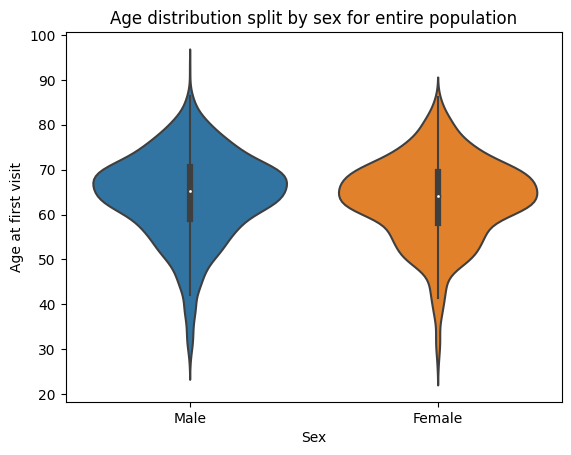

In [8]:
# Plot age distribution
df2 = df_full[['PATNO', 'EVENT_ID', 'SEX', 'AGE_AT_VISIT', 'COHORT']].copy()

df2 = df2.rename(columns={"AGE_AT_VISIT" : "Age at first visit", "SEX" : "Sex"})

df2.loc[df2['Sex'] == 1, 'Sex'] = "Male"
df2.loc[df2['Sex'] == 0, 'Sex'] = "Female"

df3 = df2[df2['EVENT_ID'] == "SC"]
df4 = df2[df2['EVENT_ID'] == "BL"]
df5 = pd.concat([df3,df4])
df5 = df5.drop_duplicates('PATNO')

sns.violinplot(data=df5, x="Sex", y="Age at first visit")
plt.title("Age distribution split by sex for entire population")
plt.savefig('ppmi_rawagesexdistribution.png')

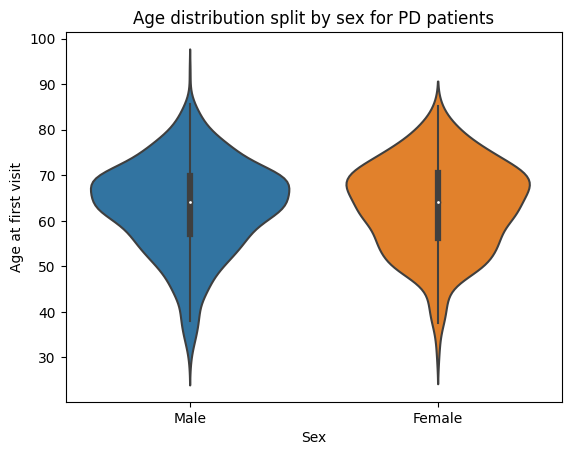

In [9]:
# Plot age distribution for PD patients
df5 = df5[df5.COHORT == 1]

sns.violinplot(data=df5, x="Sex", y="Age at first visit")
plt.title("Age distribution split by sex for PD patients")
plt.savefig('ppmi_rawPDagesexdistribution.png')

### Clean combined data

In [10]:
# Retain only patients with PD
df_full = df_full[df_full.COHORT == 1]

# Retain only the yearly visits as set by the PPMI schedule of activities
df_full = df_full[(df_full.EVENT_ID == 'BL') | (df_full.EVENT_ID == 'V04') | (df_full.EVENT_ID == 'V06') | (df_full.EVENT_ID == 'V08') | (df_full.EVENT_ID == 'V10') | (df_full.EVENT_ID == 'V12')] # | (df_full.EVENT_ID == 'V13') | (df_full.EVENT_ID == 'V14') | (df_full.EVENT_ID == 'V15')]

# Retain only patients whose status means they are enrolled, their research is complete, or that have withdrawn from further research (thus removing declined, pending, etc)
df_full = df_full[(df_full.ENROLL_STATUS == 'Enrolled') | (df_full.ENROLL_STATUS == 'Complete') | (df_full.ENROLL_STATUS == 'Withdrew')]

# Drop cohort and enroll_status columns, as they have served their purpose
df_full = df_full.drop(['COHORT', 'ENROLL_STATUS'], axis = 1)

df_full

,PATNO,EVENT_ID,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,SEX,AGE_AT_VISIT
9,3001,BL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,65.1
16,3001,V04,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,NaN,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,66.2
18,3001,V06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,39.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,67.3
20,3001,V08,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,34.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,68.3
22,3001,V10,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,1,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,35.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,69.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26030,170343,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,77.6
26048,171083,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,71.7
26203,181957,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,58.9
26356,211045,BL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [11]:
# Rename PATNO and INFODT columns
df = df_full.rename(columns = {'PATNO': 'ID', 'EVENT_ID': 'Time'})

# Set Time to visit number
timemapping = {"BL" : '0', "V04" : '1', "V06": '2', "V08" : '3', "V10": '4', "V12": '5'}
df = df.replace({"Time": timemapping})

df = df.sort_values(by=['ID','Time'], ascending = [True, True]).reset_index(drop = True)

df

,ID,Time,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,SEX,AGE_AT_VISIT
0,3001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,65.1
1,3001,1,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,NaN,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,66.2
2,3001,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,39.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,67.3
3,3001,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,34.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,68.3
4,3001,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,1,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,35.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,69.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,228315,0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,8.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,15.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,74.7
5808,230283,0,3.0,0.0,2.0,1.0,0.0,0.0,6.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,5.0,0.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,17.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,61.3
5809,231048,0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,0.0,NaN,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,71.1
5810,231983,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,1

In [12]:
# Drop records where patient was confirmed treated and non-responding, if there is a responsive record for the same visit too
df = df.sort_values(by=['ID','Time','PDSTATE'], ascending = [True, True, True]).reset_index().drop(columns=['index'])
df = df.drop_duplicates(subset=['ID','Time'], keep='first')
df

,ID,Time,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,SEX,AGE_AT_VISIT
0,3001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,65.1
1,3001,1,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,NaN,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,66.2
2,3001,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,39.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,67.3
3,3001,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,34.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,68.3
4,3001,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,69.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,228315,0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,8.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,15.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,74.7
5808,230283,0,3.0,0.0,2.0,1.0,0.0,0.0,6.0,2.0,2.0,1.0,2.0,1.0,0.0,1.0,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,5.0,0.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,17.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,61.3
5809,231048,0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,0.0,NaN,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,71.1
5810,231983,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,1

### Data imputation

<Axes: >

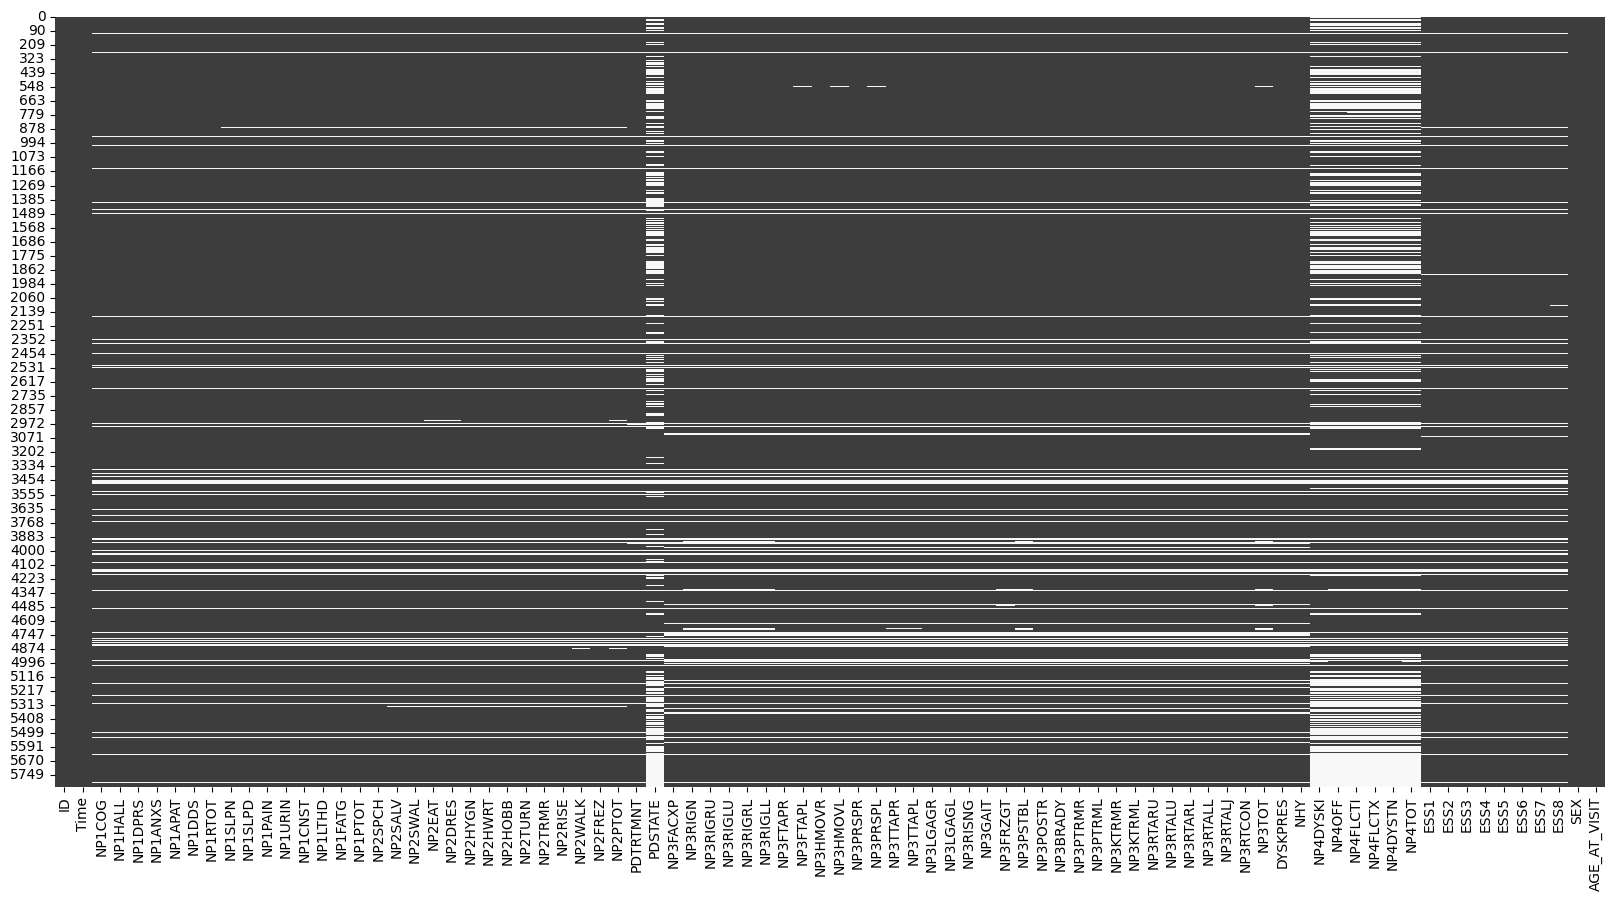

In [13]:
# Plot missingness in data
plt.figure(figsize=(20,10))

colours = ['#3D3D3D', '#F8F8F8'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours), cbar=False)

In [14]:
# Remove records that are missing over 60% of their values, as this implies barely any measurement was taken at all during the visit
df = df.dropna(axis=0, thresh=int((1-0.6)*df.shape[1] + 1))

if prune_empty_cols:
    # Remove patients who have a column that is completely empty, as we cannot use forward + backward filling on them
    df = df.groupby('ID').filter(lambda x: ~(x.isna().all().any()))

# First impute PDTRTMNT, as we need this for imputation and processing of PDSTATE data
dftemp = df[['ID','Time','PDTRTMNT']].copy()

# Impute using the chosen imputation method
if imputation_type == 1:
    # Event mean imputation
    dftemp = dftemp.groupby(['Time']).transform(lambda x: x.fillna(x.mean()))

elif imputation_type == 2:
    # Population mean imputation
    dftemp = dftemp.fillna(dftemp.mean())

elif imputation_type == 3:
    # Forward and subsequent backward filling for each patient
    IDs = dftemp["ID"].unique().tolist()
    dfs = []

    for id in IDs:
        subDf = dftemp[dftemp['ID'] == id]
        dftemp2 = subDf.copy()
        dftemp2 = dftemp2.ffill().bfill()
        dfs.append(dftemp2)

    dftemp = pd.concat(dfs)

# Round PDTRTMNT to match original significance
dftemp = dftemp.round({'PDTRTMNT': 0})
df['PDTRTMNT'] = dftemp['PDTRTMNT']

df

,ID,Time,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,SEX,AGE_AT_VISIT
0,3001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,65.1
1,3001,1,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,NaN,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,66.2
2,3001,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,NaN,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,39.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,67.3
3,3001,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,34.0,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,68.3
4,3001,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,69.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5604,148699,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0,2.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,37.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,62.2
5606,148945,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,14.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54.4
5607,148945,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,21.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,55.4
5621,151111,0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0

In [15]:
# If PDTRTMNT is 0, PDSTATE is irrelevant. However, as NaN will be imputed to 1 or 0, we should pre-emptively replace these specific NaNs to 2, as the patient is neither responsive, nor unresponsive to treatment.
mask = df['PDSTATE'].isna()
df.loc[mask, 'PDSTATE'] = np.where(df.loc[mask, 'PDTRTMNT'].eq(0), 2, np.NaN)

# Impute the remaining missing values using the chosen imputation method
if imputation_type == 1:
    # Event mean imputation
    df['ImputeTime'] = df['Time'].copy()
    df = df.groupby(['ImputeTime']).transform(lambda x: x.fillna(x.mean()))

elif imputation_type == 2:
    # Population mean imputation
    df = df.fillna(df.mean())

elif imputation_type == 3:
    # Forward and subsequent backward filling for each patient
    IDs = df["ID"].unique().tolist()
    dfs = []

    for id in IDs:
        subDf = df[df['ID'] == id]
        tempdf = subDf.copy()
        tempdf = tempdf.ffill().bfill()
        dfs.append(tempdf)

    df = pd.concat(dfs)

# Round scores to match original significance of each column
df.loc[:, df.columns != 'AGE_AT_VISIT'] = df.round(0)

df

,ID,Time,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,SEX,AGE_AT_VISIT
0,3001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,65.1
1,3001,1,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,66.2
2,3001,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,67.3
3,3001,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1.0,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,34.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,68.3
4,3001,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,69.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5604,148699,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,2.0,2.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,37.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,62.2
5606,148945,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,54.4
5607,148945,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,21.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,55.4
5621,151111,0,0.0,0.0,2.0,2.0,0.0,0.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,3.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [16]:
# Calculate UPDRSTOT using sum of partial scores
df['UPDRSTOT'] = df[['NP1RTOT','NP1PTOT','NP2PTOT','NP3TOT','NP4TOT']].sum(axis=1)

# Retain only patients that have all 6 visits
v = df.ID.value_counts()
df = df[df.ID.isin(v.index[v.gt(5)])]

df

,ID,Time,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,SEX,AGE_AT_VISIT,UPDRSTOT
0,3001,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,65.1,22.0
1,3001,1,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,66.2,35.0
2,3001,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,67.3,50.0
3,3001,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1.0,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,34.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,68.3,51.0
4,3001,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,69.2,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,73887,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,2.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,70.2,27.0
4960,73887,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,71.6,20.0
4962,73887,3,0.0,0.0,1.0,1.0,0.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,7.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,72.2,29.0
4964,73887,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,1.0,1.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

In [17]:
# Reset patient IDs
df['ID'] = df['ID'].astype('category')
df['ID'] = df['ID'].cat.codes

df

/tmp/ipykernel_609/3793016864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'] = df['ID'].astype('category')
/tmp/ipykernel_609/3793016864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ID'] = df['ID'].cat.codes


,ID,Time,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,NHY,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8,SEX,AGE_AT_VISIT,UPDRSTOT
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,65.1,22.0
1,0,1,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,66.2,35.0
2,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,67.3,50.0
3,0,3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1.0,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,34.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,68.3,51.0
4,0,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,39.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,69.2,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958,290,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,2.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,70.2,27.0
4960,290,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,71.6,20.0
4962,290,3,0.0,0.0,1.0,1.0,0.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,7.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,72.2,29.0
4964,290,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,1.0,1.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [18]:
df = df.sort_values(by=['ID','Time'], ascending = [True, True]).reset_index(drop = True)

df = df[['ID', 'Time','SEX','AGE_AT_VISIT', 'NP1COG', 'NP1HALL', 'NP1DPRS', 'NP1ANXS', 'NP1APAT', 'NP1DDS', 'NP1RTOT',
         'NP1SLPN', 'NP1SLPD', 'NP1PAIN', 'NP1URIN', 'NP1CNST', 'NP1LTHD', 'NP1FATG', 'NP1PTOT',
         'NP2SPCH', 'NP2SALV', 'NP2SWAL', 'NP2EAT', 'NP2DRES', 'NP2HYGN', 'NP2HWRT', 'NP2HOBB', 'NP2TURN', 'NP2TRMR', 'NP2RISE', 'NP2WALK', 'NP2FREZ', 'NP2PTOT',
         'PDTRTMNT', 'PDSTATE', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR',
         'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML',
         'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'DYSKPRES', 'NHY', 'NP3TOT',
         'NP4DYSKI', 'NP4OFF', 'NP4FLCTI', 'NP4FLCTX', 'NP4DYSTN', 'NP4TOT',
         'UPDRSTOT','ESS1', 'ESS2', 'ESS3', 'ESS4', 'ESS5', 'ESS6', 'ESS7', 'ESS8']]

df

,ID,Time,SEX,AGE_AT_VISIT,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP1RTOT,NP1SLPN,NP1SLPD,NP1PAIN,NP1URIN,NP1CNST,NP1LTHD,NP1FATG,NP1PTOT,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,NP2DRES,NP2HYGN,NP2HWRT,NP2HOBB,NP2TURN,NP2TRMR,NP2RISE,NP2WALK,NP2FREZ,NP2PTOT,PDTRTMNT,PDSTATE,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,NP3HMOVL,NP3PRSPR,NP3PRSPL,NP3TTAPR,NP3TTAPL,NP3LGAGR,NP3LGAGL,NP3RISNG,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP3BRADY,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON,DYSKPRES,NHY,NP3TOT,NP4DYSKI,NP4OFF,NP4FLCTI,NP4FLCTX,NP4DYSTN,NP4TOT,UPDRSTOT,ESS1,ESS2,ESS3,ESS4,ESS5,ESS6,ESS7,ESS8
0,0,0,1.0,65.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0
1,0,1,1.0,66.2,1.0,0.0,1.0,1.0,1.0,0.0,4.0,0.0,2.0,0.0,4.0,0.0,0.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
2,0,2,1.0,67.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,4.0,0.0,0.0,1.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0
3,0,3,1.0,68.3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,4.0,1.0,1.0,1.0,10.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,6.0,1.0,1.0,2.0,1.0,3.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0,4,1.0,69.2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,6.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,1.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,290,1,1.0,70.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,1.0,0.0,2.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
1742,290,2,1.0,71.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1743,290,3,1.0,72.2,0.0,0.0,1.0,1.0,0.0,0.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,0.0,7.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0
1744,290,4,1.0,73.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,2.0,1.0,1.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,1.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.

<Axes: >

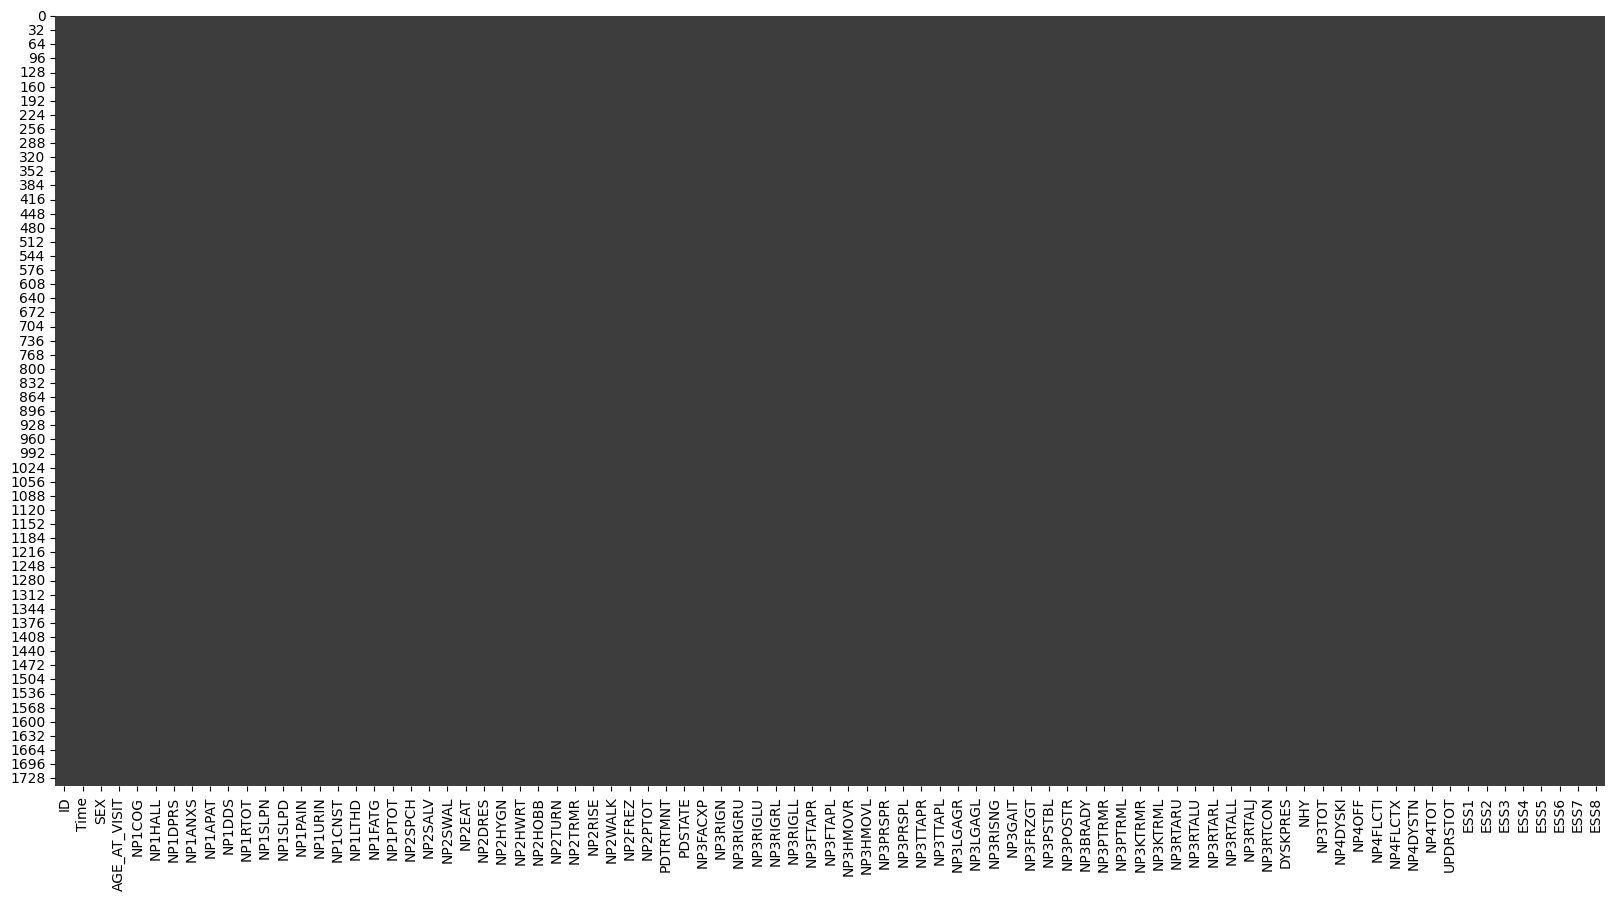

In [19]:
# Plot missingness in data
plt.figure(figsize=(20,10))

colours = ['#3D3D3D', '#F8F8F8'] 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours), cbar=False)

In [20]:
# Save the processed data
if imputation_type == 1 and prune_empty_cols:
    df.to_csv("PPMI_processed_event_pruned.csv",index=False)
elif imputation_type == 1 and not prune_empty_cols:
    df.to_csv("PPMI_processed_event.csv",index=False)

elif imputation_type == 2 and prune_empty_cols:
    df.to_csv("PPMI_processed_pop_pruned.csv",index=False)
if imputation_type == 2 and not prune_empty_cols:
    df.to_csv("PPMI_processed_pop.csv",index=False)

elif imputation_type == 3:
    df.to_csv("PPMI_processed_ffbf_pruned.csv",index=False)

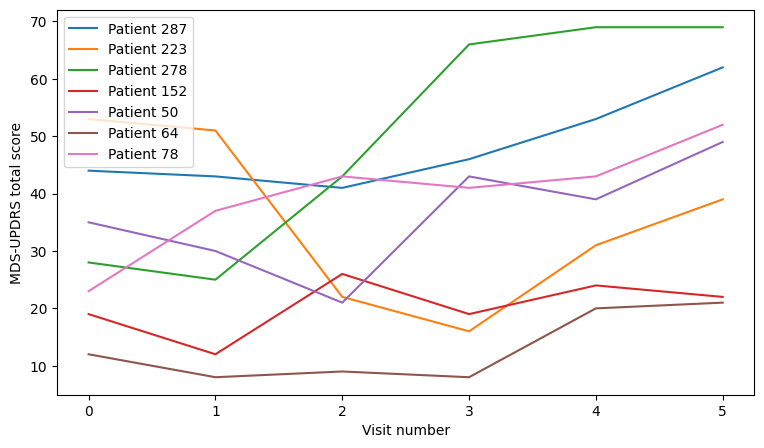

In [21]:
# Visualise the progression trajectory of various patients based on their UPDRSTOT score
patientIDlist = random.sample(range(0, int(df.shape[0]/6)), 7)
plt.figure(figsize=(9, 5))

for patientID in patientIDlist:
    seqs = df[df['ID'] == patientID]
    updrstotlist = seqs['UPDRSTOT'].tolist()
    # np1plist = seqs['NP1PTOT'].tolist()
    # np1rlist = seqs['NP1RTOT'].tolist()
    # np2plist = seqs['NP2PTOT'].tolist()
    # np3list = seqs['NP3TOT'].tolist()
    # np4list = seqs['NP4TOT'].tolist()

    plt.plot(range(6), updrstotlist, label=('Patient '+str(patientID)))
    # plt.plot(range(9), np1plist, label=('NP1PTOT '+str(patientID)))
    # plt.plot(range(9), np1rlist, label=('NP1RTOT '+str(patientID)))
    # plt.plot(range(9), np2plist, label=('NP2PTOT '+str(patientID)))
    # plt.plot(range(9), np3list, label=('NP3TOT '+str(patientID)))
    # plt.plot(range(9), np4list, label=('NP4TOT '+str(patientID)))

plt.legend()
plt.xlabel("Visit number")
plt.ylabel("MDS-UPDRS total score")
plt.savefig('ppmidatasequences.png')
plt.show()

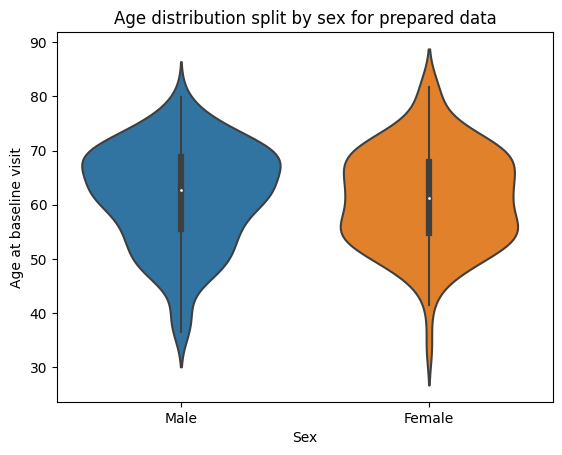

In [42]:
df2 = df.copy().rename(columns={"AGE_AT_VISIT" : "Age at baseline visit", "SEX" : "Sex"})

df2.loc[df2['Sex'] == 1, 'Sex'] = "Male"
df2.loc[df2['Sex'] == 0, 'Sex'] = "Female"

df2 = df2[df2['Time'] == "0"]

sns.violinplot(data=df2, x="Sex", y="Age at baseline visit")
plt.title("Age distribution split by sex for prepared data")
plt.savefig('ppmi_agesexdistribution.png')

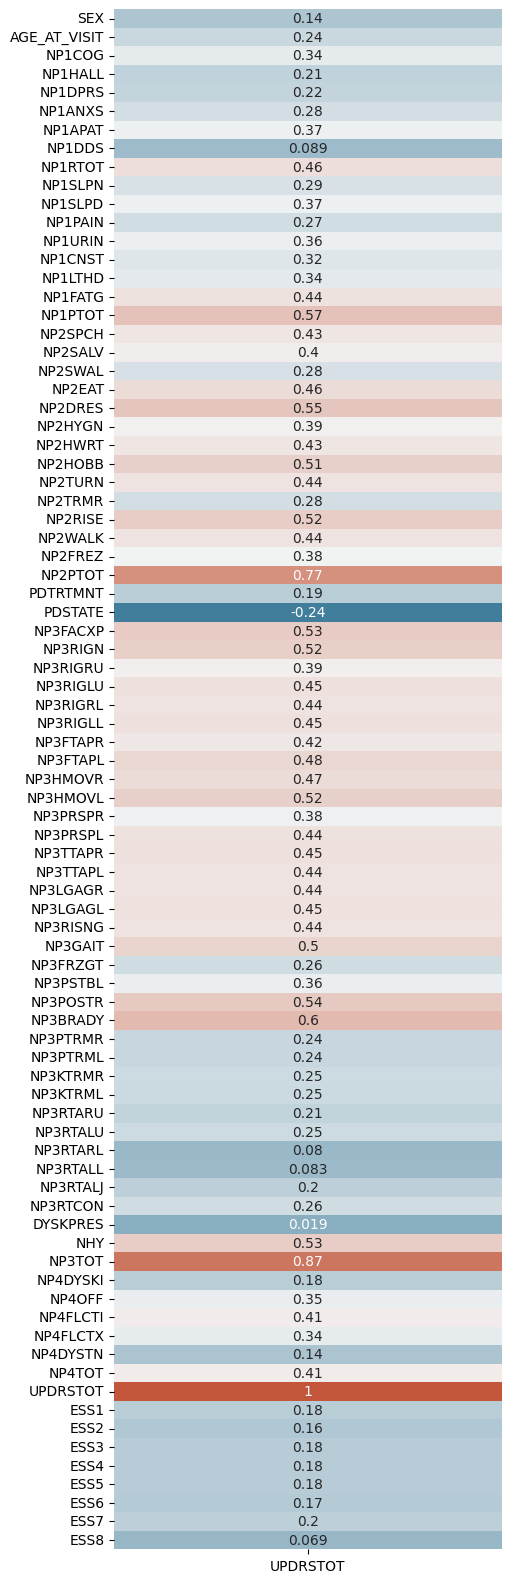

In [43]:
df3 = df.copy().loc[:, (df.columns != 'ID') & (df.columns != 'Time')]

corr = df3.corr()[['UPDRSTOT']]

f, ax = plt.subplots(figsize=(5, 20))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, annot=True, cbar=False)
plt.savefig('ppmi_correlations.png', bbox_inches='tight')